In [4]:
# Upload required files
from google.colab import files
uploaded = files.upload()

Saving battery.png to battery (1).png
Saving car.png to car (1).png
Saving charging.png to charging (1).png
Saving dataset.csv to dataset (1).csv
Saving flag.png to flag (1).png
Saving rock.png to rock (1).png


In [5]:
# Install and import required packages
!pip install ipywidgets
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import heapq
import time
import random
import math
import pandas as pd

# Load icons
icons = {}
for icon in ['car', 'flag', 'rock', 'battery', 'charging']:
    icons[icon] = cv2.imread(f"{icon}.png", cv2.IMREAD_UNCHANGED)
    assert icons[icon] is not None, f"Failed to load {icon}.png"

# Load dataset
dataset = pd.read_csv("dataset.csv")
print("✅ Dataset loaded. Sample:")
print(dataset.head())


✅ Dataset loaded. Sample:
    x   y obstacle_type  is_charging_station  battery_level  path_length  \
0  15   6        static                    1          17.74           73   
1  28   4        static                    1          86.70           91   
2  19  11       dynamic                    1          95.29           43   
3   4   9       dynamic                    0          18.87           12   
4  16   6          none                    0          66.10           44   

   navigation_success  
0                   1  
1                   1  
2                   0  
3                   0  
4                   1  


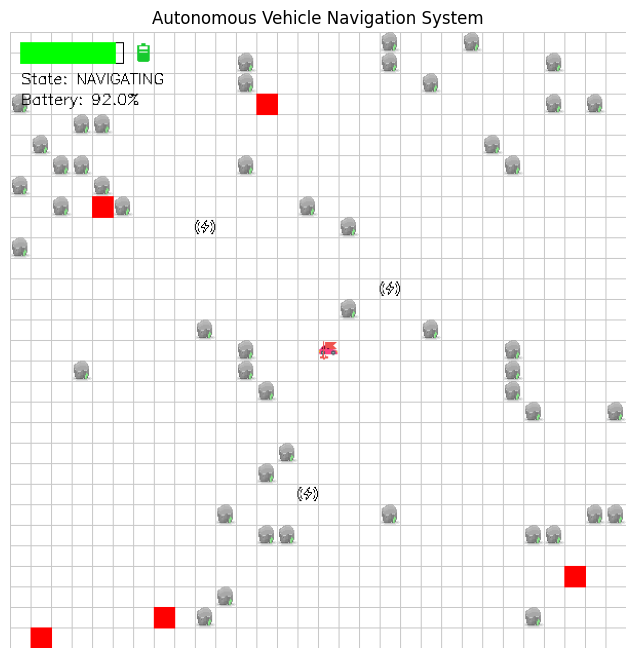

In [6]:
def overlay_icon(img, icon, pos, size=(20, 20)):
    icon = cv2.resize(icon, size)
    x, y = pos
    h, w = icon.shape[:2]
    if y + h > img.shape[0] or x + w > img.shape[1]:
        return
    if icon.shape[2] == 4:
        alpha = icon[:, :, 3] / 255.0
        for c in range(3):
            img[y:y+h, x:x+w, c] = alpha * icon[:, :, c] + (1 - alpha) * img[y:y+h, x:x+w, c]

class PathPlanner:
    def __init__(self, grid):
        self.grid = grid
        self.dirs_8 = [(0,1),(1,0),(0,-1),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    def heuristic(self, a, b):
        return math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)
    def a_star(self, start, goal):
        open_set = [(0, start)]
        came_from, g_score = {}, {start: 0}
        f_score = {start: self.heuristic(start, goal)}
        while open_set:
            _, current = heapq.heappop(open_set)
            if current == goal:
                path = []
                while current in came_from:
                    path.append(current)
                    current = came_from[current]
                return path[::-1]
            for dx, dy in self.dirs_8:
                neighbor = (current[0] + dx, current[1] + dy)
                if 0 <= neighbor[0] < len(self.grid) and 0 <= neighbor[1] < len(self.grid[0]) and self.grid[neighbor[0]][neighbor[1]] == 0:
                    move_cost = 1.414 if dx and dy else 1.0
                    tentative_g = g_score[current] + move_cost
                    if tentative_g < g_score.get(neighbor, float('inf')):
                        came_from[neighbor] = current
                        g_score[neighbor] = tentative_g
                        f_score[neighbor] = tentative_g + self.heuristic(neighbor, goal)
                        heapq.heappush(open_set, (f_score[neighbor], neighbor))
        return []

class AutonomousVehicle:
    def __init__(self):
        self.grid_size = (30, 30)
        self.cell_size = 20
        self.step_delay = 0.2
        self.emergency = False
        self.init_vision()
        self.init_battery()
        self.init_ui()
        self.pos = (0, 0)
        self.goal = None
        self.path = []
        self.state = "idle"
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        self.img_display = None
        plt.axis('off')
        plt.title("Autonomous Vehicle Navigation System")
        plt.close()

    def init_vision(self):
        self.grid = np.zeros(self.grid_size, dtype=int)
        self.dynamic_obs = set()
        self.charging_stations = set()
        for _ in range(50):
            x, y = random.randint(0, self.grid_size[0]-1), random.randint(0, self.grid_size[1]-1)
            self.grid[x][y] = 1
        for _ in range(random.randint(3,5)):
            while True:
                x, y = random.randint(0, self.grid_size[0]-1), random.randint(0, self.grid_size[1]-1)
                if self.grid[x][y] == 0:
                    self.charging_stations.add((x, y))
                    break
        for _ in range(5):
            while True:
                x, y = random.randint(0, self.grid_size[0]-1), random.randint(0, self.grid_size[1]-1)
                if self.grid[x][y] == 0 and (x, y) not in self.charging_stations:
                    self.dynamic_obs.add((x, y))
                    break

    def init_battery(self):
        self.battery = 100
        self.consumption_rate = 0.5

    def init_ui(self):
        self.dest_x = widgets.IntText(value=15, min=0, max=self.grid_size[0]-1, description='X:')
        self.dest_y = widgets.IntText(value=15, min=0, max=self.grid_size[1]-1, description='Y:')
        self.start_btn = widgets.Button(description="Start Navigation")
        self.stop_btn = widgets.Button(description="Emergency Stop")
        self.battery_slider = widgets.FloatSlider(value=100, min=0, max=100, description='Battery:')
        self.status_output = widgets.Output()
        self.start_btn.on_click(self.start_navigation)
        self.stop_btn.on_click(self.emergency_stop)
        display(widgets.VBox([
            widgets.HBox([self.dest_x, self.dest_y]),
            widgets.HBox([self.start_btn, self.stop_btn]),
            self.battery_slider,
            self.status_output
        ]))

    def log_data(self, goal, success):
        log_entry = {
            "start_x": self.pos[0], "start_y": self.pos[1],
            "goal_x": goal[0], "goal_y": goal[1],
            "battery_level": self.battery,
            "path_length": len(self.path),
            "success": int(success)
        }
        df_log = pd.DataFrame([log_entry])
        df_log.to_csv("navigation_log.csv", mode='a', header=not os.path.exists("navigation_log.csv"), index=False)
        files.download("navigation_log.csv")

    def emergency_stop(self, btn):
        self.emergency = True
        self.state = "emergency"
        with self.status_output:
            clear_output()
            print("EMERGENCY STOP ACTIVATED!")

    def start_navigation(self, btn):
        self.emergency = False
        with self.status_output:
            clear_output()
            print("Starting navigation...")
        self.goal = (self.dest_x.value, self.dest_y.value)
        self.navigate_to(self.goal)

    def navigate_to(self, goal):
        if self.battery < 20:
            self.go_to_charging_station()
            if self.emergency: return
        planner = PathPlanner(self.get_current_grid())
        self.path = planner.a_star(self.pos, goal)
        if not self.path:
            with self.status_output:
                print("No path found to destination!")
            return
        self.follow_path(goal)
        if not self.emergency and self.pos == goal:
            with self.status_output:
                self.log_data(goal, success=True)
                print("Destination reached!")

    def go_to_charging_station(self):
        with self.status_output:
            print("Low battery! Finding nearest charging station...")
        nearest_station = None
        min_dist = float('inf')
        planner = PathPlanner(self.get_current_grid())
        for station in self.charging_stations:
            path = planner.a_star(self.pos, station)
            if path and len(path) < min_dist:
                min_dist = len(path)
                nearest_station = station
                self.path = path
        if not nearest_station:
            with self.status_output:
                print("No charging station reachable!")
            return
        self.follow_path(nearest_station, charging=True)
        if not self.emergency:
            with self.status_output:
                print("Charging...")
            while self.battery < 80 and not self.emergency:
                self.battery = min(100, self.battery + 2)
                self.battery_slider.value = self.battery
                self.update_visualization()
                time.sleep(self.step_delay)
            with self.status_output:
                print(f"Charged to {self.battery:.1f}%")

    def follow_path(self, goal, charging=False):
        self.state = "charging" if charging else "navigating"
        while self.path and not self.emergency:
            self.pos = self.path.pop(0)
            self.battery = max(0, self.battery - self.consumption_rate)
            self.battery_slider.value = self.battery
            if random.random() < 0.2:
                self.update_dynamic_obstacles()
            self.update_visualization()
            time.sleep(self.step_delay)
            if self.battery < 20 and not charging:
                with self.status_output:
                    print("Battery critically low!")
                break

    def update_dynamic_obstacles(self):
        new_obs = set()
        for obs in self.dynamic_obs:
            if random.random() < 0.3:
                dx, dy = random.choice([(0,1),(1,0),(0,-1),(-1,0)])
                new_pos = (obs[0]+dx, obs[1]+dy)
                if (0 <= new_pos[0] < self.grid_size[0] and
                    0 <= new_pos[1] < self.grid_size[1] and
                    self.grid[new_pos[0]][new_pos[1]] == 0):
                    new_obs.add(new_pos)
                else:
                    new_obs.add(obs)
            else:
                new_obs.add(obs)
        self.dynamic_obs = new_obs

    def get_current_grid(self):
        grid = self.grid.copy()
        for obs in self.dynamic_obs:
            if 0 <= obs[0] < grid.shape[0] and 0 <= obs[1] < grid.shape[1]:
                grid[obs[0]][obs[1]] = 2
        return grid

    def create_visualization(self):
        img = np.ones((self.grid_size[0]*self.cell_size, self.grid_size[1]*self.cell_size, 3), dtype=np.uint8)*255
        for i in range(self.grid_size[0]+1):
            cv2.line(img, (0, i*self.cell_size), (img.shape[1], i*self.cell_size), (200,200,200), 1)
        for j in range(self.grid_size[1]+1):
            cv2.line(img, (j*self.cell_size, 0), (j*self.cell_size, img.shape[0]), (200,200,200), 1)
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                if self.grid[i][j] == 1:
                    overlay_icon(img, icons['rock'], (j*self.cell_size, i*self.cell_size))
                elif (i, j) in self.charging_stations:
                    overlay_icon(img, icons['charging'], (j*self.cell_size, i*self.cell_size))
        for obs in self.dynamic_obs:
            cv2.rectangle(img, (obs[1]*self.cell_size, obs[0]*self.cell_size), ((obs[1]+1)*self.cell_size, (obs[0]+1)*self.cell_size), (0,0,255), -1)
        if self.path:
            for (i, j) in self.path:
                cv2.circle(img, (j*self.cell_size+self.cell_size//2, i*self.cell_size+self.cell_size//2), 2, (0,255,0), -1)
        overlay_icon(img, icons['car'], (self.pos[1]*self.cell_size, self.pos[0]*self.cell_size))
        if self.goal:
            overlay_icon(img, icons['flag'], (self.goal[1]*self.cell_size, self.goal[0]*self.cell_size))
        batt_width = 100
        charge_width = int(batt_width * (self.battery / 100))
        cv2.rectangle(img, (10,10), (10+batt_width,30), (0,0,0), 1)
        cv2.rectangle(img, (10,10), (10+charge_width,30), (0,255,0) if self.battery > 20 else (0,0,255), -1)
        overlay_icon(img, icons['battery'], (10+batt_width+5, 5), (30,30))
        cv2.putText(img, f"State: {self.state.upper()}", (10,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1)
        cv2.putText(img, f"Battery: {self.battery:.1f}%", (10,70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1)
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    def update_visualization(self):
        img = self.create_visualization()
        if self.img_display is None:
            self.img_display = self.ax.imshow(img)
            display(self.fig)
        else:
            self.img_display.set_array(img)
        clear_output(wait=True)
        display(self.fig)
        display(widgets.VBox([
            widgets.HBox([self.dest_x, self.dest_y]),
            widgets.HBox([self.start_btn, self.stop_btn]),
            self.battery_slider,
            self.status_output
        ]))

av = AutonomousVehicle()
